# Эксперименты для датасетов DDTI (УЗИ щитовидной железы) и BUS-BRA (УЗИ молочных желез)

---



## Загрузка данных



In [ ]:
!git clone https://github.com/ArtemKushnir/ThyroidScan.git

Cloning into 'ThyroidScan'...
remote: Enumerating objects: 706, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 706 (delta 137), reused 199 (delta 89), pack-reused 410 (from 1)
Receiving objects: 100% (706/706), 9.71 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (353/353), done.


In [ ]:
%cd /content/ThyroidScan
!pwd

/content/ThyroidScan
/content/ThyroidScan


In [1]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"","key":	""}
import json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(api_token, f)

!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

!kaggle datasets download -d orvile/bus-bra-a-breast-ultrasound-dataset
!unzip -q bus-bra-a-breast-ultrasound-dataset.zip

{"username": "", "key": ""}Dataset URL: https://www.kaggle.com/datasets/orvile/bus-bra-a-breast-ultrasound-dataset
License(s): other
 88% 112M/128M [00:00<00:00, 1.17GB/s]
100% 128M/128M [00:00<00:00, 1.17GB/s]


In [ ]:
!kaggle datasets download -d dasmehdixtr/ddti-thyroid-ultrasound-images
!unzip -q ddti-thyroid-ultrasound-images.zip -d ddti

Dataset URL: https://www.kaggle.com/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images
License(s): other
  0% 0.00/17.2M [00:00<?, ?B/s]
100% 17.2M/17.2M [00:00<00:00, 1.02GB/s]


In [ ]:
from src.data_loaders.split_files import split_files_by_type

In [ ]:
split_files_by_type("ddti")

In [ ]:
!pip install opencv-python
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.1 MB/s eta 0:00:00


## Оценка качества сегментации

Качество сегментации оценивалось по 4 метрикам, вычисляемым через **перекрытие масок**:

1. **Intersection over Union (IoU)**  
   Отношение площади пересечения к площади объединения:  
   $$\text{IoU} = \frac{|GT \cap PM|}{|GT \cup PM|}$$

2. **Dice coefficient (F1-score)**  
   Гармоническое среднее точности и полноты:  
   $$\text{Dice} = \frac{2 \cdot |GT \cap PM|}{|GT| + |PM|}$$

3. **Precision (точность)**  
   Доля правильных предсказаний в выделенной области:  
   $$\text{Precision} = \frac{|GT \cap PM|}{|PM|}$$

4. **Recall (полнота)**  
   Доля захваченной истинной области:  
   $$\text{Recall} = \frac{|GT \cap PM|}{|GT|}$$

Где:
- $GT$ - Ground Truth (истинная маска)
- $PM$ - Predicted Mask (сегментированная маска)
- $\cap$ - логическое И (пересечение)
- $\cup$ - логическое ИЛИ (объединение)
- $|\cdot|$ - площадь маски (число пикселей)



**Стратегия оценки:**  
Для анализа использовалась наилучшая маска из набора масок каждого изображения, так как основная задача - сбор признаков из выделенных областей.

**Обоснование выбора метрик:**
1. **Dice coefficient** - основная метрика, так как обеспечивает сбалансированную оценку для несбалансированных классов:
   $$ Dice = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$

2. **Recall** - особо учитывается, поскольку важна максимальная покрываемость целевой области для извлечения признаков, даже в ущерб точности (во избежание потери значимых данных).

In [ ]:
from src.data_loaders.ddti_loader import DDTILoader
from src.data_loaders.bus_bra_loader import BUSLoader
from src.image_processing.collecting_features.feature_extractor import FeatureExtractor
from src.image_processing.preprocessing.cropper import Cropper
from src.image_processing.segmentation.algorithms.wave_algorithm.points_finder import WavePointFinder
from src.image_processing.segmentation.algorithms.wave_algorithm.wave_segmenter import WaveSegmenter
from src.image_processing.segmentation.image_segmenter import ImageSegmenter
from src.image_processing.segmentation.mask_selector import MaskSelector

In [ ]:
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import time
import json
import csv
from statistics import mean, stdev
import random
random.seed(42)

## Визуализация

In [ ]:
def plot_results(results):
    plt.style.use('default')
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'grid.color': '0.8',
        'grid.linestyle': '--',
        'grid.alpha': 0.7
    })

    points = np.array(results['points_numbers'])
    metrics = {
        'Recall': np.array(results['recall']),
        'IoU': np.array(results['iou']),
        'F1 (Dice)': np.array(results['dice']),
        'Precision': np.array(results['precision'])
    }
    times = np.array(results['time_avg']) if 'time_avg' in results else np.array(results['time'])

    fig_size = (12, 6)
    fontsize = 12
    title_fontsize = 14
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#ffc0cb']

    plt.figure(figsize=fig_size)

    for (label, values), color in zip(metrics.items(), colors):
        plt.plot(points, values, 'o-', color=color, markersize=8, linewidth=2, label=label)

    plt.xlabel('Points Number', fontsize=fontsize)
    plt.ylabel('Metric Value', fontsize=fontsize)
    plt.title('Accuracy vs Points Number', fontsize=title_fontsize)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=fig_size)

    if 'time_std' in results:
        time_std = np.array(results['time_std'])
        plt.errorbar(points, times, yerr=time_std, fmt='o-',
                    color='#9b59b6', markersize=8, linewidth=2,
                    capsize=5, ecolor='#8e44ad')
    else:
        plt.plot(points, times, 'o-', color='#9b59b6', markersize=8, linewidth=2)

    for i, (p, t) in enumerate(zip(points, times)):
        plt.text(p, t, f"{t:.1f}s", ha='center', va='bottom',
                fontsize=9, color='black')

    plt.xlabel('Points Number', fontsize=fontsize)
    plt.ylabel('Time (sec)', fontsize=fontsize)
    plt.title('Execution Time vs Points Number', fontsize=title_fontsize)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=fig_size)

    norm = Normalize(vmin=min(points), vmax=max(points))
    scatter = plt.scatter(times, metrics['F1 (Dice)'],
                         c=points, cmap='viridis',
                         s=150, alpha=0.7, norm=norm)

    for i, (t, d, p) in enumerate(zip(times, metrics['F1 (Dice)'], points)):
        plt.text(t, d, f'{p}', ha='center', va='center',
                fontsize=9, color='black')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Points Number', fontsize=fontsize)

    plt.xlabel('Execution Time (sec)', fontsize=fontsize)
    plt.ylabel('Dice', fontsize=fontsize)
    plt.title('Accuracy (Dice) vs Execution Time', fontsize=title_fontsize)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Сохранение в файл

In [ ]:
def save_results(results, output_file):
    csv_data = []
    for i in range(len(results['points_numbers'])):
        row = {
            'points_number': results['points_numbers'][i],
            'time_avg': results['time']['avg'][i],
            'time_std': results['time']['std'][i]
        }

        for metric in results['metrics']:
            row[f"{metric.lower()}_avg"] = results['metrics'][metric]['avg'][i]
            row[f"{metric.lower()}_std"] = results['metrics'][metric]['std'][i]

        csv_data.append(row)

    if output_file.endswith('.json'):
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=4)
    else:
        with open(output_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=csv_data[0].keys())
            writer.writeheader()
            writer.writerows(csv_data)

In [ ]:
def load_results_for_plots(csv_file):
    results = {
        'points_numbers': [],
        'recall': [],
        'iou': [],
        'dice': [],
        'precision': [],
        'time_avg': []
    }

    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        fieldnames = reader.fieldnames
        has_time_std = 'time_std' in fieldnames

    if has_time_std:
        results['time_std'] = []

    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)

        for row in reader:
            results['points_numbers'].append(int(row['points_number']))
            results['recall'].append(float(row['recall_avg']))
            results['iou'].append(float(row['iou_avg']))
            results['dice'].append(float(row['f1 (dice)_avg']))
            results['precision'].append(float(row['precision_avg']))
            results['time_avg'].append(float(row['time_avg']))

            if has_time_std:
                results['time_std'].append(float(row['time_std']))

    for key in results:
        results[key] = np.array(results[key])

    return results

## Метрики

In [ ]:
def calculate_mean_segmentation_metrics(image_list: list):
    all_candidate_iou = []
    all_candidate_dice = []
    all_candidate_precision = []
    all_candidate_recall = []
    per_image_avg_recall_for_overlap_rate = []

    for image in image_list:
        true_mask = image.true_mask
        masks = image.segmented_masks

        recalls_for_this_image_candidates = []

        for mask in masks:
            iou = jaccard_score(true_mask.ravel(), mask.ravel(), pos_label=255, zero_division=0)
            dice = f1_score(true_mask.ravel(), mask.ravel(), pos_label=255, zero_division=0)
            precision = precision_score(true_mask.ravel(), mask.ravel(), pos_label=255, zero_division=0)
            recall = recall_score(true_mask.ravel(), mask.ravel(), pos_label=255, zero_division=0)

            all_candidate_iou.append(iou)
            all_candidate_dice.append(dice)
            all_candidate_precision.append(precision)
            all_candidate_recall.append(recall)
            recalls_for_this_image_candidates.append(recall)

            avg_recall_for_image = np.mean(recalls_for_this_image_candidates)
            per_image_avg_recall_for_overlap_rate.append(avg_recall_for_image)

    results = {'avg_candidate_iou': np.mean(all_candidate_iou),
               'avg_candidate_dice': np.mean(all_candidate_dice),
               'avg_candidate_precision': np.mean(all_candidate_precision),
               'avg_candidate_recall': np.mean(all_candidate_recall),
               'avg_overlap_rate_per_image': np.mean(per_image_avg_recall_for_overlap_rate)}

    return results


def calculate_best_mask_segmentation_metrics(image_list: list):
    best_iou_list = []
    best_dice_list = []
    best_precision_list = []
    best_recall_list = []

    for image in image_list:
        true_mask = image.true_mask
        masks = image.segmented_masks

        iou_scores = [
            jaccard_score(true_mask.ravel(), mask.ravel(), pos_label=255, zero_division=0)
            for mask in masks
        ]
        best_mask_idx = np.argmax(iou_scores)
        best_mask = masks[best_mask_idx]

        best_iou = iou_scores[best_mask_idx]
        best_dice = f1_score(true_mask.ravel(), best_mask.ravel(), pos_label=255, zero_division=0)
        best_precision = precision_score(true_mask.ravel(), best_mask.ravel(), pos_label=255, zero_division=0)
        best_recall = recall_score(true_mask.ravel(), best_mask.ravel(), pos_label=255, zero_division=0)

        best_iou_list.append(best_iou)
        best_dice_list.append(best_dice)
        best_precision_list.append(best_precision)
        best_recall_list.append(best_recall)

    results = {
        'best_iou_mean': np.mean(best_iou_list) if best_iou_list else 0,
        'best_dice_mean': np.mean(best_dice_list) if best_dice_list else 0,
        'best_precision_mean': np.mean(best_precision_list) if best_precision_list else 0,
        'best_recall_mean': np.mean(best_recall_list) if best_recall_list else 0
    }

    return results

## Эксперименты для DDTI

### Описание датасета

Датасет [DDTI](https://www.kaggle.com/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images?select=100.xml) содержит:
- Исходные данные: **466 изображений** с корректными XML-аннотациями
- После предобработки (разделения двойных изображений): **626 УЗИ-изображений**

Все гиперпараметры были предварительно оптимизированы с помощью **Optuna** (фреймворк для автоматического подбора параметров).

### Исследовательские вопросы

#### RQ1: Сравнение методов сегментации
**Как показывает себя волновой алгоритм (метод областей) в сравнении с существующими подходами к сегментации УЗИ щитовидной железы?**

Критерий сравнения:
*   Точность сегментации (IoU, Dice)



#### RQ2: Оптимальное количество точек
**Какое количество точек обеспечивает наилучший баланс между:**
- Качеством сегментации
- Временем выполнения



Планируемые эксперименты:
- Тестирование с 20, 24, 28, 32, 36, 40, 44 точками, 3 запуска
- Анализ графика "качество-время"

In [ ]:
def run_experiments(xml_path, images_path, points_numbers, mask_number=10, output_file="results.csv"):
    results = {
        'points_numbers': np.array(points_numbers),
        'metrics': {
            'Recall': {'avg': [], 'std': []},
            'IoU': {'avg': [], 'std': []},
            'F1 (Dice)': {'avg': [], 'std': []},
            'Precision': {'avg': [], 'std': []}
        },
        'time': {
            'avg': [],
            'std': []
        }
    }

    loader = DDTILoader(xml_path, images_path)
    image_list = loader.load_dataset()
    cropper = Cropper()
    cropped_list = cropper.transform(image_list)

    for points_num in points_numbers:
        print(f"\nRunning experiment with points_num={points_num}, mask_num={mask_number}")

        run_data = {
            'Recall': [], 'IoU': [], 'F1 (Dice)': [], 'Precision': [], 'time': []
        }

        for run in range(3):
            start_time = time.perf_counter()

            pipeline = Pipeline([
                ("segmenter", ImageSegmenter(WaveSegmenter(18, 4), WavePointFinder(points_num, 83, 36))),
                ("selector", MaskSelector(mask_number))
            ])

            result_list = pipeline.fit_transform(cropped_list)
            res = calculate_best_mask_segmentation_metrics(result_list)

            run_data['time'].append(time.perf_counter() - start_time)
            run_data['Recall'].append(res['best_recall_mean'])
            run_data['IoU'].append(res['best_iou_mean'])
            run_data['F1 (Dice)'].append(res['best_dice_mean'])
            run_data['Precision'].append(res['best_precision_mean'])

        for metric in results['metrics']:
            results['metrics'][metric]['avg'].append(mean(run_data[metric]))
            results['metrics'][metric]['std'].append(stdev(run_data[metric]) if len(run_data[metric]) > 1 else 0.0)

        results['time']['avg'].append(mean(run_data['time']))
        results['time']['std'].append(stdev(run_data['time']) if len(run_data['time']) > 1 else 0.0)

    for metric in results['metrics']:
        results['metrics'][metric]['avg'] = np.array(results['metrics'][metric]['avg'])
        results['metrics'][metric]['std'] = np.array(results['metrics'][metric]['std'])

    results['time']['avg'] = np.array(results['time']['avg'])
    results['time']['std'] = np.array(results['time']['std'])

    save_results(results, output_file)
    return results

In [ ]:
xml_path = "xml_files"
images_path = "images"

points_numbers = [20, 24, 28, 32, 36, 40, 44]

ddti_results = run_experiments(xml_path, images_path, points_numbers, mask_number=10, output_file="../ddti_results.csv")

 Error with parsing svg in 203_1.jpg
 Error with parsing svg in 205_1.jpg
 Error with parsing svg in 176_1.jpg
 Error with parsing svg in 166_1.jpg
 Error with parsing svg in 165_1.jpg
 Error with parsing svg in 127_1.jpg
 Error with parsing svg in 197_1.jpg
 Error with parsing svg in 54_1.jpg

Running experiment with points_num=20, mask_num=10

Running experiment with points_num=24, mask_num=10

Running experiment with points_num=28, mask_num=10

Running experiment with points_num=32, mask_num=10

Running experiment with points_num=36, mask_num=10

Running experiment with points_num=40, mask_num=10

Running experiment with points_num=44, mask_num=10


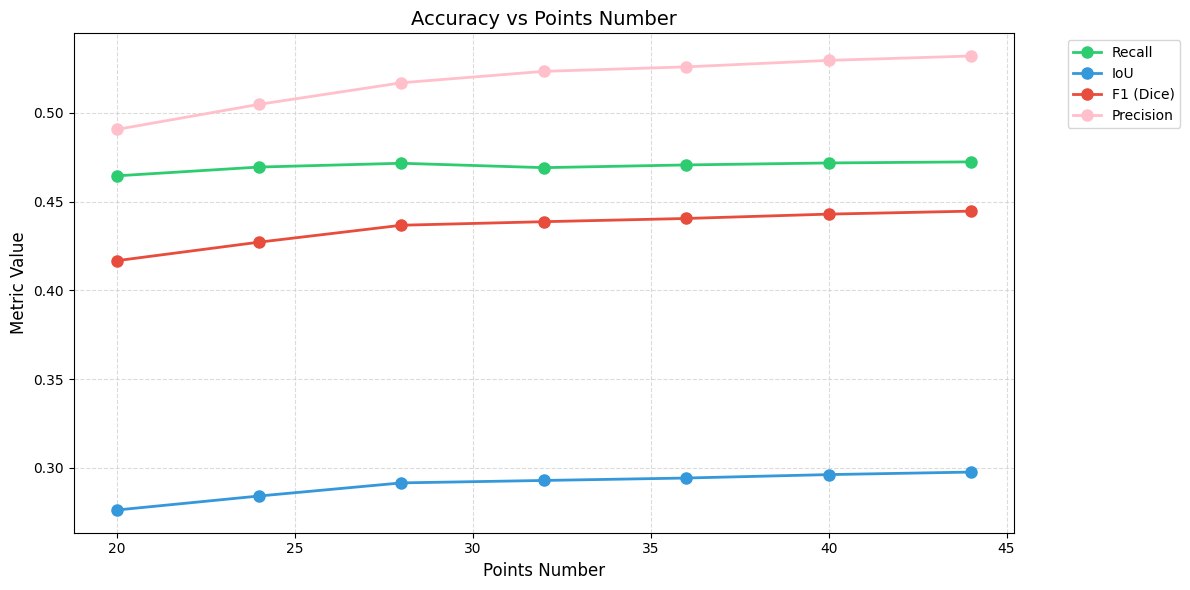

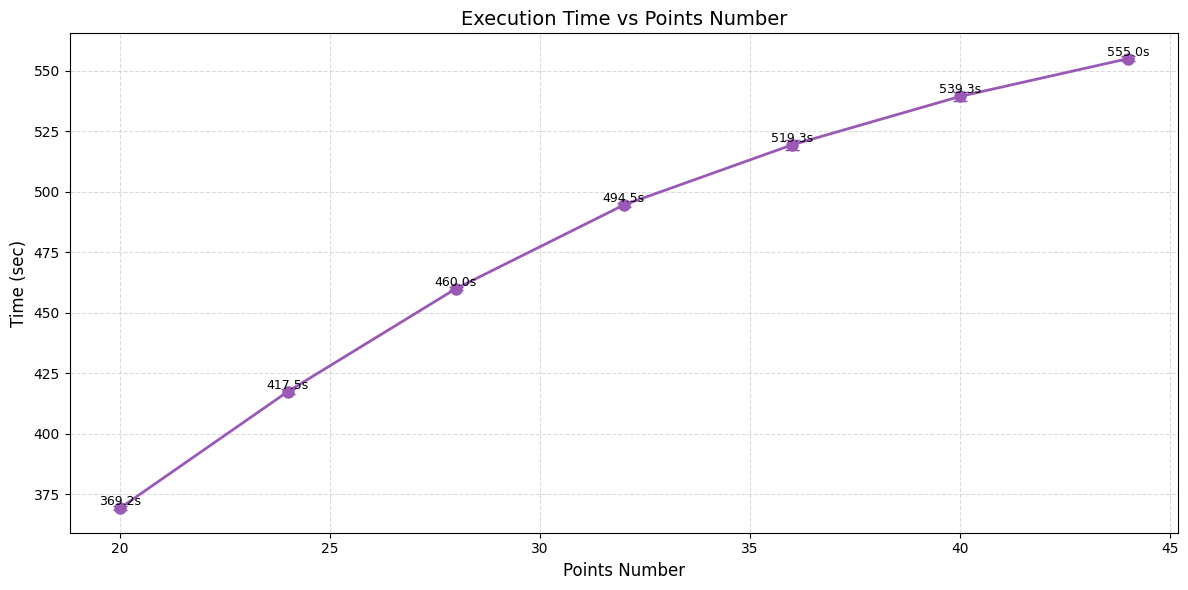

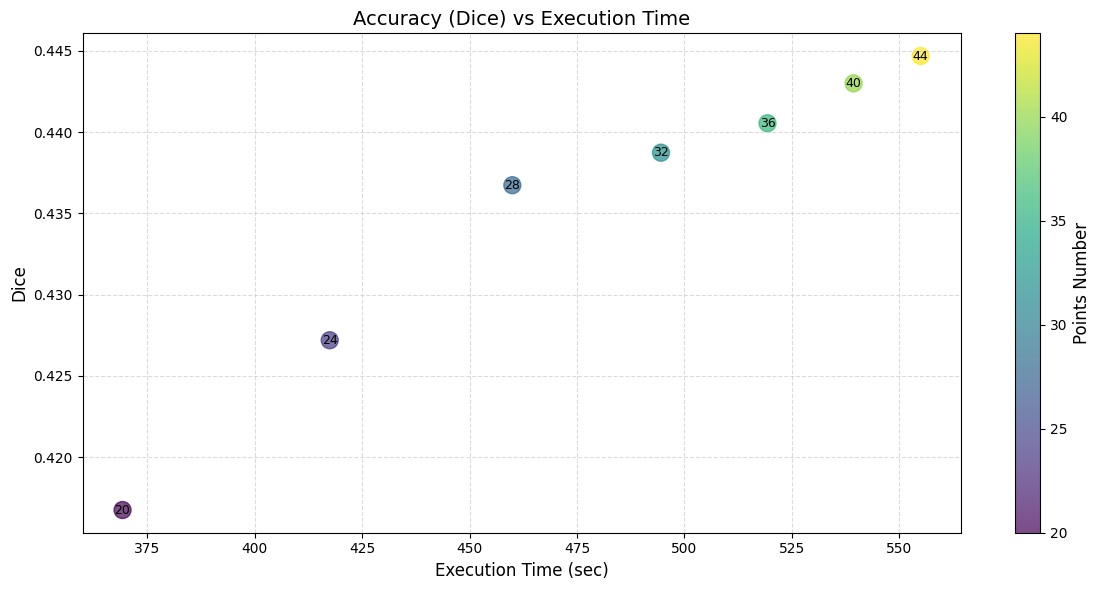

In [ ]:
plot_results(load_results_for_plots("../ddti_results.csv"))

## Эксперименты для BUS-BRA

Датасет BUS-BRA состоит из 1875 изображений УЗИ молочных желез формата PNG и такого же количества масок, деффектов обнаружено не было.

Исследовательские вопросы как и для DDTI.

Эксперименты с точками проводились на подвыборке из 650 изображений, поскольку датасет довольно большой.

In [ ]:
def run_bus_experiments(
    data_path,
    points_numbers,
    mask_number=10,
    sample_size=650,
    iter=3
    ):

    results = {
        'points_numbers': np.array(points_numbers),
        'metrics': {
            'Recall': {'avg': [], 'std': []},
            'IoU': {'avg': [], 'std': []},
            'F1 (Dice)': {'avg': [], 'std': []},
            'Precision': {'avg': [], 'std': []},
        },
        'time': {
            'avg': [],
            'std': []
        }
    }

    loader = BUSLoader(data_path)
    image_list = loader.load_dataset()
    cropped_list = random.sample(image_list, sample_size)

    for points_num in points_numbers:
        print(f"\nRunning experiment with points_num={points_num}, mask_num={mask_number}")

        run_metrics = {
            'Recall': [],
            'IoU': [],
            'F1 (Dice)': [],
            'Precision': [],
            'time': []
        }

        for run in range(iter):
            start_time = time.perf_counter()

            pipeline = Pipeline([
                ("segmenter", ImageSegmenter(
                    WaveSegmenter(17, 4),
                    WavePointFinder(points_num, 85, 40))),
                ("selector", MaskSelector(mask_number))
            ])

            result_list = pipeline.fit_transform(cropped_list)
            res = calculate_best_mask_segmentation_metrics(result_list)

            run_time = time.perf_counter() - start_time
            run_metrics['time'].append(run_time)
            run_metrics['Recall'].append(res['best_recall_mean'])
            run_metrics['IoU'].append(res['best_iou_mean'])
            run_metrics['F1 (Dice)'].append(res['best_dice_mean'])
            run_metrics['Precision'].append(res['best_precision_mean'])

        for metric in ['Recall', 'IoU', 'F1 (Dice)', 'Precision']:
            results['metrics'][metric]['avg'].append(mean(run_metrics[metric]))
            results['metrics'][metric]['std'].append(
                stdev(run_metrics[metric]) if len(run_metrics[metric]) > 1 else 0.0
            )

        results['time']['avg'].append(mean(run_metrics['time']))
        results['time']['std'].append(
            stdev(run_metrics['time']) if len(run_metrics['time']) > 1 else 0.0
        )

    for metric in results['metrics']:
        results['metrics'][metric]['avg'] = np.array(results['metrics'][metric]['avg'])
        results['metrics'][metric]['std'] = np.array(results['metrics'][metric]['std'])

    results['time']['avg'] = np.array(results['time']['avg'])
    results['time']['std'] = np.array(results['time']['std'])

    return results

In [ ]:
data_path = "BUSBRA"
points_numbers = [20, 24, 28, 32, 36, 40, 44]

results = run_bus_experiments(data_path, points_numbers, mask_number=10, iter=1)


Running experiment with points_num=20, mask_num=10

Running experiment with points_num=24, mask_num=10

Running experiment with points_num=28, mask_num=10

Running experiment with points_num=32, mask_num=10

Running experiment with points_num=36, mask_num=10

Running experiment with points_num=40, mask_num=10

Running experiment with points_num=44, mask_num=10


In [ ]:
save_results(results, "../busbra_results.csv")

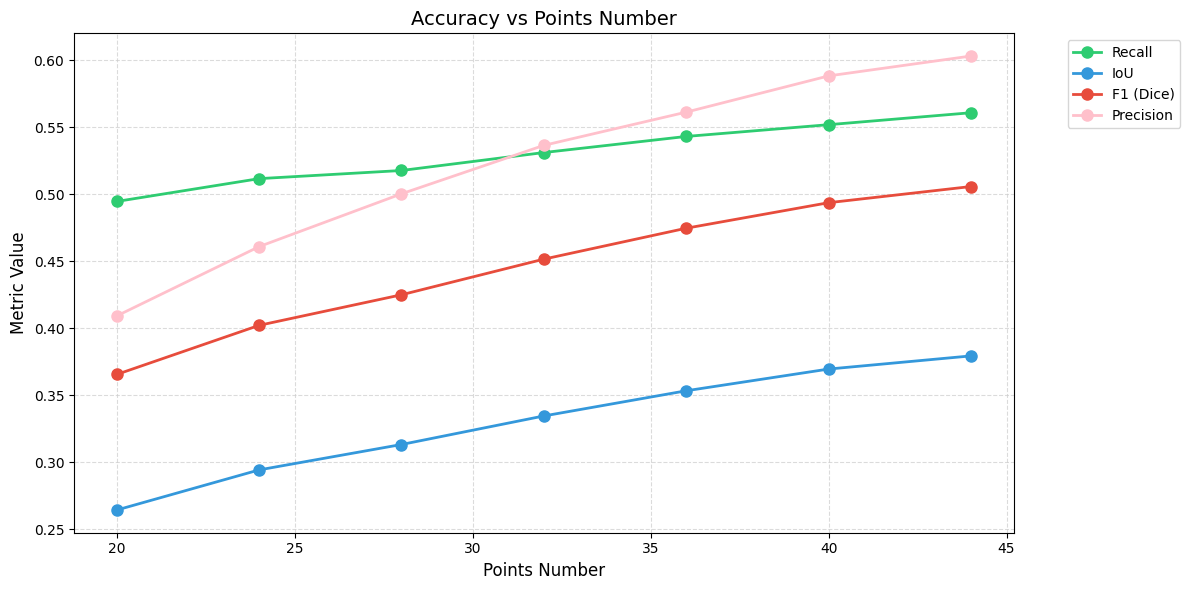

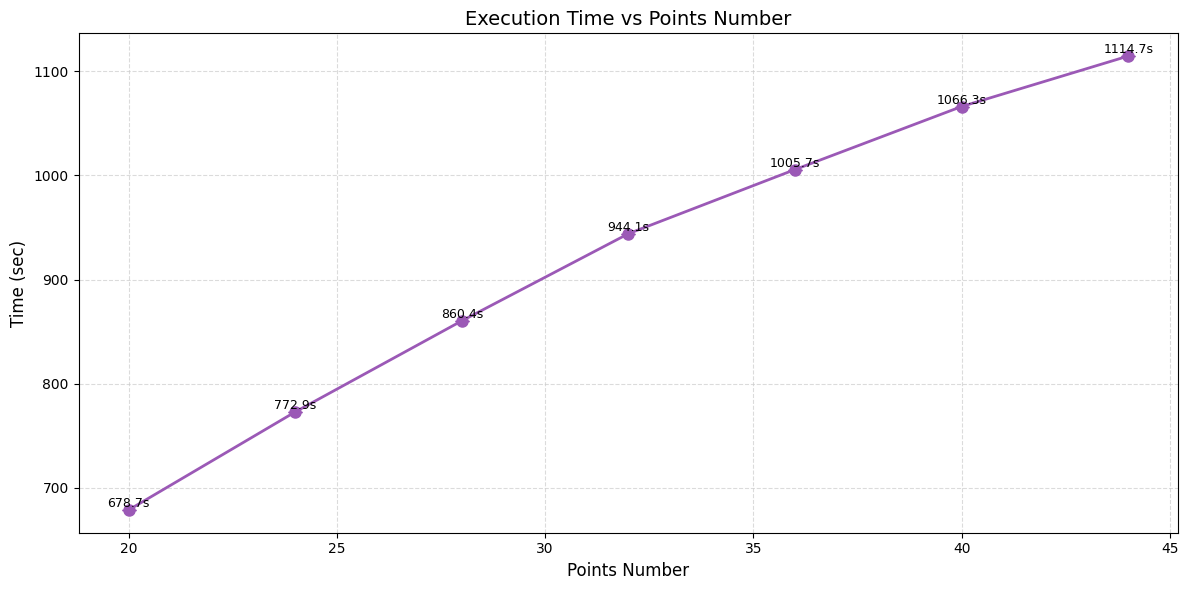

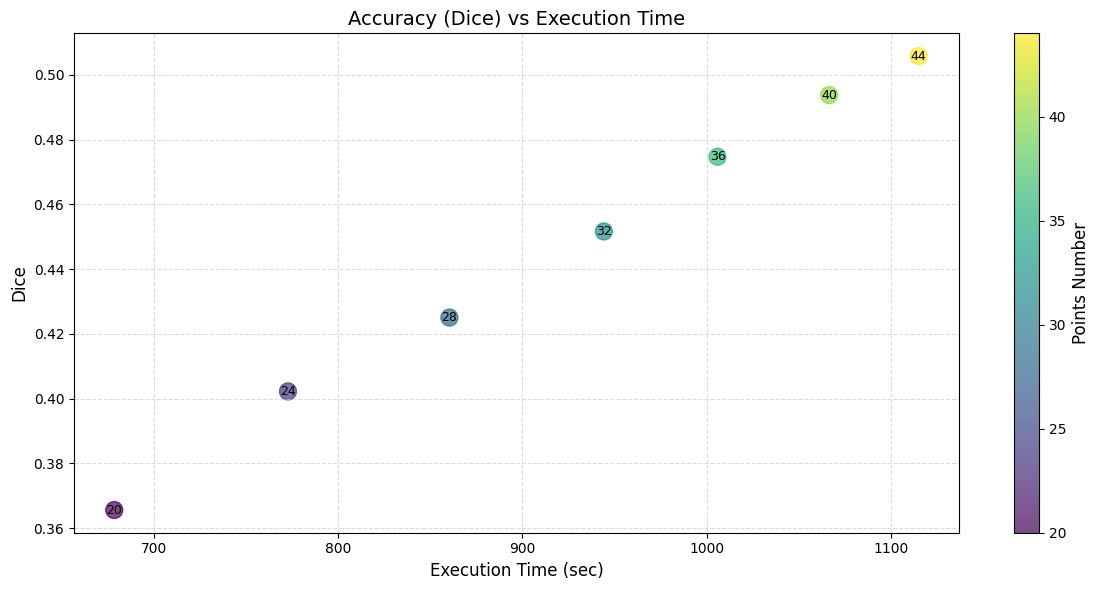

In [ ]:
plot_results(load_results_for_plots("../busbra_results.csv"))

In [ ]:
data_path = "BUSBRA"

loader = BUSLoader(data_path)
cropped_list = loader.load_dataset()

pipeline = Pipeline([
                ("segmenter", ImageSegmenter(
                    WaveSegmenter(17, 4),
                    WavePointFinder(32, 85, 40))),
                ("selector", MaskSelector(32)),
                ("extractor", FeatureExtractor())
            ])

result_list = pipeline.fit_transform(cropped_list)

/content/ThyroidScan/src/image_processing/collecting_features/feature_extractor.py:122: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skewness": float(skew(region)),
/content/ThyroidScan/src/image_processing/collecting_features/feature_extractor.py:123: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": float(kurtosis(region)),


In [ ]:
best_res = calculate_best_mask_segmentation_metrics(result_list)

In [ ]:
for metric_name, value in best_res.items():
    print(f"{metric_name}: {value:.4f}")

best_iou_mean: 0.3542
best_dice_mean: 0.4736
best_precision_mean: 0.5609
best_recall_mean: 0.5598
